In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import vanillaWH
import integrator_tools

%matplotlib inline

# configuring plots
#plt.rc('text', usetex=True)            # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 14})  # increase font size

In [31]:
4.738829669966265

4.738829669966265

In [32]:
# initial conditions from Mikkola 1997
# could also late test w/ restricted 3-body problem: https://w.astro.berkeley.edu/~echiang/classmech/final.pdf

# particle array as [x, y, z, vx, vy, vz, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([-2.0, 0., 0., 0., -0.7, 0., 2.])
p2 = np.array([0., 60., 0.01, -0.095, 0.0, 0.01, 0.9])

sim_jacobi = np.stack([p0, p1, p2])
masses = sim_jacobi[:,-1]

sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

P_1195 = 2*np.pi*np.sqrt(1.195**3 / 3)

P_1195 = 4.73

print(P_1195)
print('Period =', P_1195)

timestep = 1./30. * P_1195
N_steps = 12500

energy_error = np.zeros(N_steps)
E0 = integrator_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0], orbit_soln[:,2,0] = sim_jacobi[:,0], sim_jacobi[:,1], sim_jacobi[:,2]

start = time.time()

for i in range(N_steps):
    
    # drift
    sim_jacobi = vanillaWH.drift(sim_jacobi, sim, h=timestep/2)
    sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
    
    # kick
    sim_jacobi = vanillaWH.kick(sim_jacobi, sim, h=timestep)
    
    # drift
    sim_jacobi = vanillaWH.drift(sim_jacobi, sim, h=timestep/2)
    sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = integrator_tools.energy_fn(sim)
    energy_error[i] = (E-E0)/E0

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

4.73
Period = 4.73
time to integrate = 6.7 s


Integrate with timestep = 0.15766666666666668 for 12500 steps = 416.6333333333333 years.


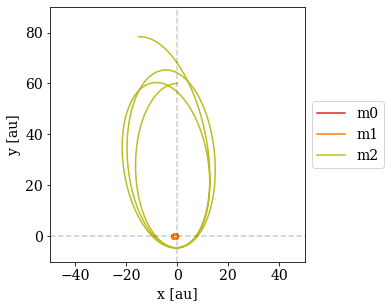

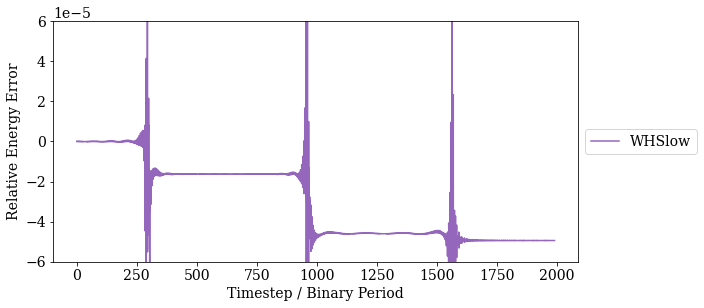

In [33]:
orbital_periods = np.arange(N_steps) / (2*np.pi)
print('Integrate with timestep =', timestep, 'for', N_steps, 'steps =', years[-1], 'years.')

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m1', c='tab:orange')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
plt.xlim(-50,50)
plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbital_periods, energy_error, label='WHSlow', c='tab:purple')
#plt.yscale('log')
plt.ylim(-6e-5, 6e-5)
plt.xlabel('Timestep / Binary Period')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()


In [34]:
# particle array as [x, y, z, vx, vy, vz, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
p2 = np.array([0., 60., 0.01, -0.095, 0.0, 0.01, 0.9])

sim_jacobi = np.stack([p0, p1, p2])
masses = sim_jacobi[:,-1]

sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

sim_com = integrator_tools.move_to_com(sim)

test_sim = rebound.Simulation()

test_sim.add(x=sim[0,0], y=sim[0,1], z=sim[0,2], vx=sim[0,3], vy=sim[0,4], vz=sim[0,5], m=sim[0,6])
test_sim.add(x=sim[1,0], y=sim[1,1], z=sim[1,2], vx=sim[1,3], vy=sim[1,4], vz=sim[1,5], m=sim[1,6])
test_sim.add(x=sim[2,0], y=sim[2,1], z=sim[2,2], vx=sim[2,3], vy=sim[2,4], vz=sim[2,5], m=sim[2,6])

print(test_sim.particles[1].a, test_sim.particles[1].e)
print(test_sim.particles[2].a, test_sim.particles[2].e)

1.195219123505976 0.6733333333333333
32.26473677977889 0.8596153827118228


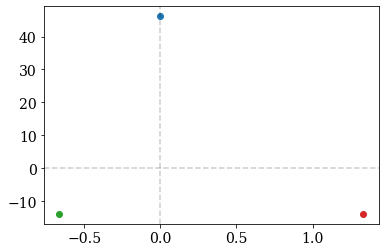

1.195219123505976 0.6733333333333333
32.26473677977889 0.8596153827118228


In [35]:
plt.scatter(test_sim.particles[0].x,test_sim.particles[0].y, c='tab:red')
plt.scatter(test_sim.particles[1].x,test_sim.particles[1].y, c='tab:green')
plt.scatter(test_sim.particles[2].x,test_sim.particles[2].y, c='tab:blue')
plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.show()

print(test_sim.particles[1].a,test_sim.particles[1].e)
print(test_sim.particles[2].a,test_sim.particles[2].e)


In [36]:
sim_rebound = rebound.Simulation()
sim_rebound.move_to_com()

sim_rebound.add(x=sim_com[0,0], y=sim_com[0,1], z=sim_com[0,2], vx=sim_com[0,3], vy=sim_com[0,4], vz=sim_com[0,5], m=sim_com[0,6])
sim_rebound.add(x=sim_com[1,0], y=sim_com[1,1], z=sim_com[1,2], vx=sim_com[1,3], vy=sim_com[1,4], vz=sim_com[1,5], m=sim_com[1,6])
sim_rebound.add(x=sim_com[2,0], y=sim_com[2,1], z=sim_com[2,2], vx=sim_com[2,3], vy=sim_com[2,4], vz=sim_com[2,5], m=sim_com[2,6])

sim_rebound.integrator='whfast'
sim_rebound.dt = timestep
sim_rebound.move_to_com()

energy_error_reb = np.zeros(N_steps) 
E0 = sim_rebound.calculate_energy()

orbit_soln_rebound = np.zeros((len(sim), 3, N_steps))
diff0, diff1, diff2 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)

rel_diff0, rel_diff1, rel_diff2 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)

start = time.time()

for i in range(N_steps):
    sim_rebound.step() 
    
    E = sim_rebound.calculate_energy()
    energy_error_reb[i] = (E-E0)/E0
    
    p0 = np.array([sim_rebound.particles[0].x,sim_rebound.particles[0].y,sim_rebound.particles[0].z, \
                   sim_rebound.particles[0].vx,sim_rebound.particles[0].vy,sim_rebound.particles[0].vz, \
                   sim_rebound.particles[0].m])
    p1 = np.array([sim_rebound.particles[1].x,sim_rebound.particles[1].y,sim_rebound.particles[1].z, \
                   sim_rebound.particles[1].vx,sim_rebound.particles[1].vy,sim_rebound.particles[1].vz, \
                   sim_rebound.particles[1].m])
    p2 = np.array([sim_rebound.particles[2].x,sim_rebound.particles[2].y,sim_rebound.particles[2].z, \
                   sim_rebound.particles[2].vx,sim_rebound.particles[2].vy,sim_rebound.particles[2].vz, \
                   sim_rebound.particles[2].m])
    sim = np.stack([p0, p1, p2])
    
    sim_jacobi = integrator_tools.inertial_to_jacobi(sim)
    
    orbit_soln_rebound[0,:,i] = sim_jacobi[0,:3]
    orbit_soln_rebound[1,:,i] = sim_jacobi[1,:3]
    orbit_soln_rebound[2,:,i] = sim_jacobi[2,:3]
    
    x0 = orbit_soln_rebound[0,0,i]
    y0 = orbit_soln_rebound[0,1,i]
    z0 = orbit_soln_rebound[0,2,i]
    dx0 = x0-orbit_soln[0,0,i]
    dy0 = y0-orbit_soln[0,1,i]
    dz0 = z0-orbit_soln[0,2,i]
    diff0[i] = np.sqrt(dx0**2 + dy0**2 + dz0**2)
    rel_diff0[i] = diff0[i] / np.sqrt(x0**2 + y0**2 + z0**2)
    
    x1 = orbit_soln_rebound[1,0,i]
    y1 = orbit_soln_rebound[1,1,i]
    z1 = orbit_soln_rebound[1,2,i]
    dx1 = x1-orbit_soln[1,0,i]
    dy1 = y1-orbit_soln[1,1,i]
    dz1 = z1-orbit_soln[1,2,i]
    diff1[i] = np.sqrt(dx1**2 + dy1**2 + dz1**2)
    rel_diff1[i] = diff1[i] / np.sqrt(x1**2 + y1**2 + z1**2)
    
    x2 = orbit_soln_rebound[2,0,i]
    y2 = orbit_soln_rebound[2,1,i]
    z2 = orbit_soln_rebound[2,2,i]
    dx2 = x2-orbit_soln[2,0,i]
    dy2 = y2-orbit_soln[2,1,i]
    dz2 = z2-orbit_soln[2,2,i]
    diff2[i] = np.sqrt(dx2**2 + dy2**2 + dz2**2)
    rel_diff2[i] = diff2[i] / np.sqrt(x2**2 + y2**2 + z2**2)
    
end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 1.0 s


Integrate with timestep = 0.15766666666666668 for 12500 steps = 416.6333333333333 years.


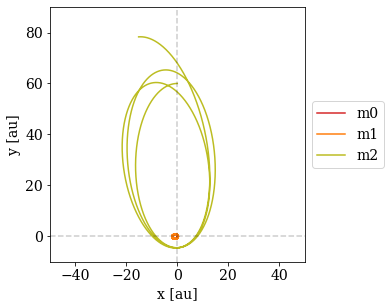

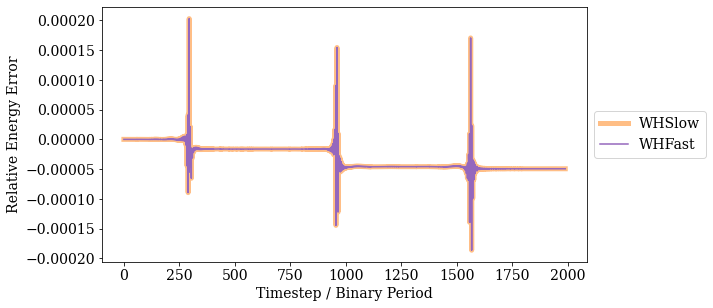

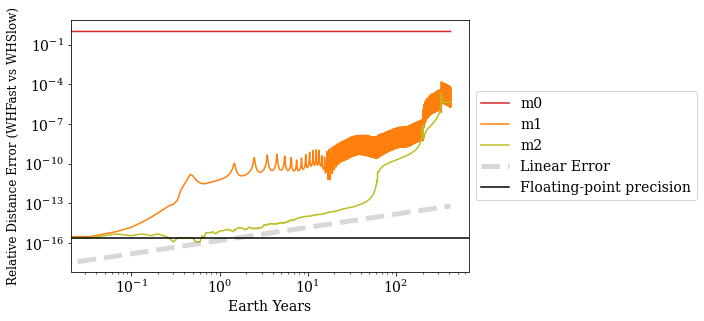

In [37]:
orbital_periods = np.arange(N_steps) / (2*np.pi)
print('Integrate with timestep =', timestep, 'for', N_steps, 'steps =', years[-1], 'years.')

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln_rebound[0,0], orbit_soln_rebound[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln_rebound[1,0], orbit_soln_rebound[1,1], label='m1', c='tab:orange')
plt.plot(orbit_soln_rebound[2,0], orbit_soln_rebound[2,1], label='m2', c='tab:olive')
plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
plt.xlim(-50,50)
plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()


plt.figure(figsize=(10,4.5))
plt.plot(orbital_periods, energy_error, lw=5, alpha=0.5, label='WHSlow', c='tab:orange')
plt.plot(orbital_periods, energy_error_reb, label='WHFast', c='tab:purple')
#plt.yscale('log')
#plt.ylim(-1e-4, 1e-4)
plt.xlabel('Timestep / Binary Period')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(years, rel_diff0, label='m0', c='tab:red')
plt.plot(years, rel_diff1, label='m1', c='tab:orange')
plt.plot(years, rel_diff2, label='m2', c='tab:olive')
plt.plot(years, 5e-18*np.arange(N_steps),ls = '--', c='grey', lw=5, alpha=0.3, label='Linear Error')
plt.axhline(sys.float_info.epsilon, label='Floating-point precision', c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Earth Years')
plt.ylabel('Relative Distance Error (WHFast vs WHSlow)', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS_error.jpg', dpi=300)
plt.show()